In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchmetrics import Accuracy

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

import timeit
from time import time

from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"Using device: {device}")

PyTorch version: 2.0.1+cu117
Torchvision version: 0.15.2+cu117
Using device: cpu


/home/mikeasta/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_data = datasets.MNIST(
    root="data",
    train=True,
    transform=ToTensor(),
    target_transform=None,
    download=True
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    transform=ToTensor(),
    target_transform=None,
    download=True
)


In [3]:
train_data, test_data

(Dataset MNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [4]:
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [5]:
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

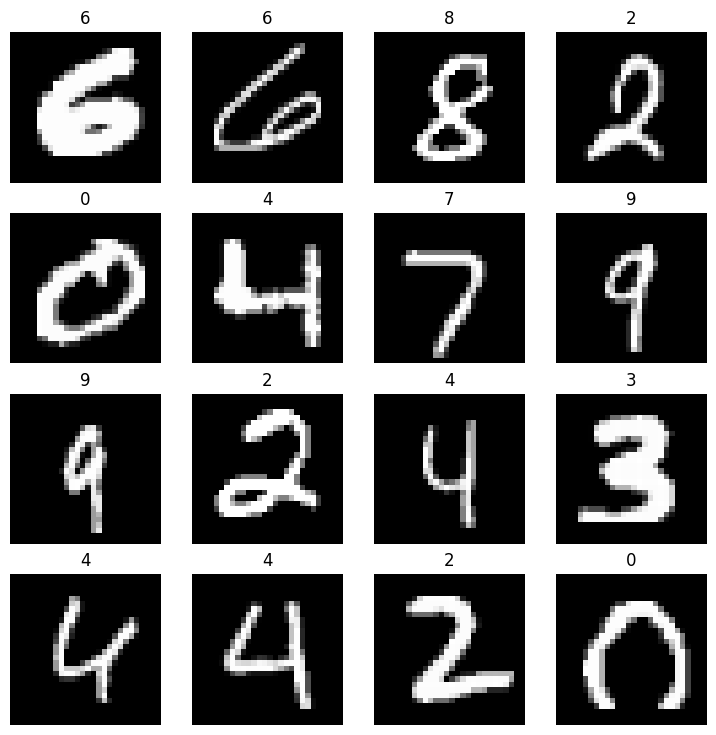

In [6]:
torch.manual_seed(42)
rows, cols = 4, 4
fig = plt.figure(figsize=(9, 9))
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    image, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(image.squeeze(), cmap="gray")
    plt.axis(False)
    plt.title(label)

In [7]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(f"Train loader length: {len(train_dataloader)} of batches with size {BATCH_SIZE}")
print(f"Test loader length: {len(test_dataloader)} of batches with size {BATCH_SIZE}")

Train loader length: 1875 of batches with size 32
Test loader length: 313 of batches with size 32


In [8]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f81070e53d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f8107285e90>)

In [9]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
print(f"Feature batch shape (batch of images): {train_features_batch.shape}")
print(f"Labels batch shape: {train_labels_batch.shape}")

Feature batch shape (batch of images): torch.Size([32, 1, 28, 28])
Labels batch shape: torch.Size([32])


In [10]:
class MNISTClassifier(nn.Module):
    def __init__(
        self,
        input_shape: int,
        output_shape: int,
        hidden_channels: int = 10,
        hidden_units: int = 10,
    ) -> None:
        super().__init__()

        # 28x28 -> 14x14
        self.conv_net_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_channels,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_channels,
                out_channels=hidden_channels,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # 14x14 -> 7x7
        self.conv_net_block_2 = nn.Sequential(
            nn.Conv2d(hidden_channels, hidden_channels, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, hidden_channels, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # 7x7 -> 10
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_net_block_1(x)
        x = self.conv_net_block_2(x)
        x = self.classifier(x)
        return x

    def evaluate(
        self,
        data_loader: torch.utils.data.DataLoader,
        loss_fn: torch.nn.Module,
        device: torch.device = device) -> dict:
        loss, acc = 0, 0
        accuracy = Accuracy(task="multiclass", num_classes=len(class_names))
        self.eval()
        with torch.inference_mode():
            for X, y in data_loader:
                X, y = X.to(device), y.to(device)
                
                y_pred = self(X)
                test_loss = loss_fn(y_pred, y)
                test_acc = accuracy(y_pred.argmax(dim=1), y)
                
                loss += test_loss
                acc += test_acc
            
            loss /= len(data_loader)
            acc /= len(data_loader)
        
        return {
            "model_name": self.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc.item()
        }
        

    def fit(
        self,
        data_loader: torch.utils.data.DataLoader,
        loss_fn: torch.nn.Module,
        optimizer: torch.optim.Optimizer,
        device: torch.device = device,
        epochs: int = 5
        ) -> None:
        start_timestamp = time()
        self.train()
        accuracy = Accuracy(task="multiclass", num_classes=len(class_names))
        for epoch in tqdm(range(epochs)):
            loss, acc = 0, 0
            for batch, (X, y) in enumerate(data_loader):
                X, y = X.to(device), y.to(device)

                y_pred = self(X)
                #print(y_pred.shape, y.shape)

                train_loss = loss_fn(y_pred, y) 
                train_acc = accuracy(y_pred.argmax(dim=1), y).item()

                loss += train_loss
                acc += train_acc

                optimizer.zero_grad()
                train_loss.backward()
                optimizer.step()

                if batch % 500 == 0:
                    print(f"- Batch {batch}: loss - {train_loss.item():5f} | accuracy - {train_acc:5f}.")
            
            loss /= len(data_loader)
            acc /= len(data_loader)
            print(f"Epoch {epoch+1}: loss - {loss.item():5f} | accuracy - {acc:5f}.")
        end_timestamp = time()
        print(f"Training finished in {end_timestamp - start_timestamp} seconds.")
        

In [11]:
model = MNISTClassifier(
    input_shape = 1,
    output_shape = len(class_names)
)
model

MNISTClassifier(
  (conv_net_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_net_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

model.fit(
    data_loader=train_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer)

  0%|          | 0/5 [00:00<?, ?it/s]

- Batch 0: loss - 2.293103 | accuracy - 0.125000.
- Batch 500: loss - 0.038385 | accuracy - 1.000000.
- Batch 1000: loss - 0.191910 | accuracy - 0.875000.
- Batch 1500: loss - 0.058494 | accuracy - 0.968750.


 20%|██        | 1/5 [00:41<02:47, 41.95s/it]

Epoch 1: loss - 0.281104 | accuracy - 0.905400.
- Batch 0: loss - 0.075312 | accuracy - 1.000000.
- Batch 500: loss - 0.012450 | accuracy - 1.000000.
- Batch 1000: loss - 0.194988 | accuracy - 0.937500.
- Batch 1500: loss - 0.026323 | accuracy - 1.000000.


 40%|████      | 2/5 [01:23<02:04, 41.57s/it]

Epoch 2: loss - 0.068170 | accuracy - 0.978800.
- Batch 0: loss - 0.003979 | accuracy - 1.000000.
- Batch 500: loss - 0.001273 | accuracy - 1.000000.
- Batch 1000: loss - 0.017065 | accuracy - 1.000000.
- Batch 1500: loss - 0.010110 | accuracy - 1.000000.


 60%|██████    | 3/5 [02:05<01:23, 41.98s/it]

Epoch 3: loss - 0.054691 | accuracy - 0.982383.
- Batch 0: loss - 0.018281 | accuracy - 1.000000.
- Batch 500: loss - 0.010176 | accuracy - 1.000000.
- Batch 1000: loss - 0.031306 | accuracy - 1.000000.
- Batch 1500: loss - 0.002443 | accuracy - 1.000000.


 80%|████████  | 4/5 [02:39<00:38, 38.92s/it]

Epoch 4: loss - 0.046779 | accuracy - 0.985233.
- Batch 0: loss - 0.002452 | accuracy - 1.000000.
- Batch 500: loss - 0.001489 | accuracy - 1.000000.
- Batch 1000: loss - 0.038773 | accuracy - 0.968750.
- Batch 1500: loss - 0.227415 | accuracy - 0.968750.


100%|██████████| 5/5 [03:14<00:00, 38.99s/it]

Epoch 5: loss - 0.041281 | accuracy - 0.987183.
Training finished in 194.95192170143127 seconds.


In [13]:
result = model.evaluate(
    data_loader=test_dataloader,
    loss_fn=loss_fn
)

print(result)

{'model_name': 'MNISTClassifier', 'model_loss': 0.04805513098835945, 'model_acc': 0.9845247864723206}


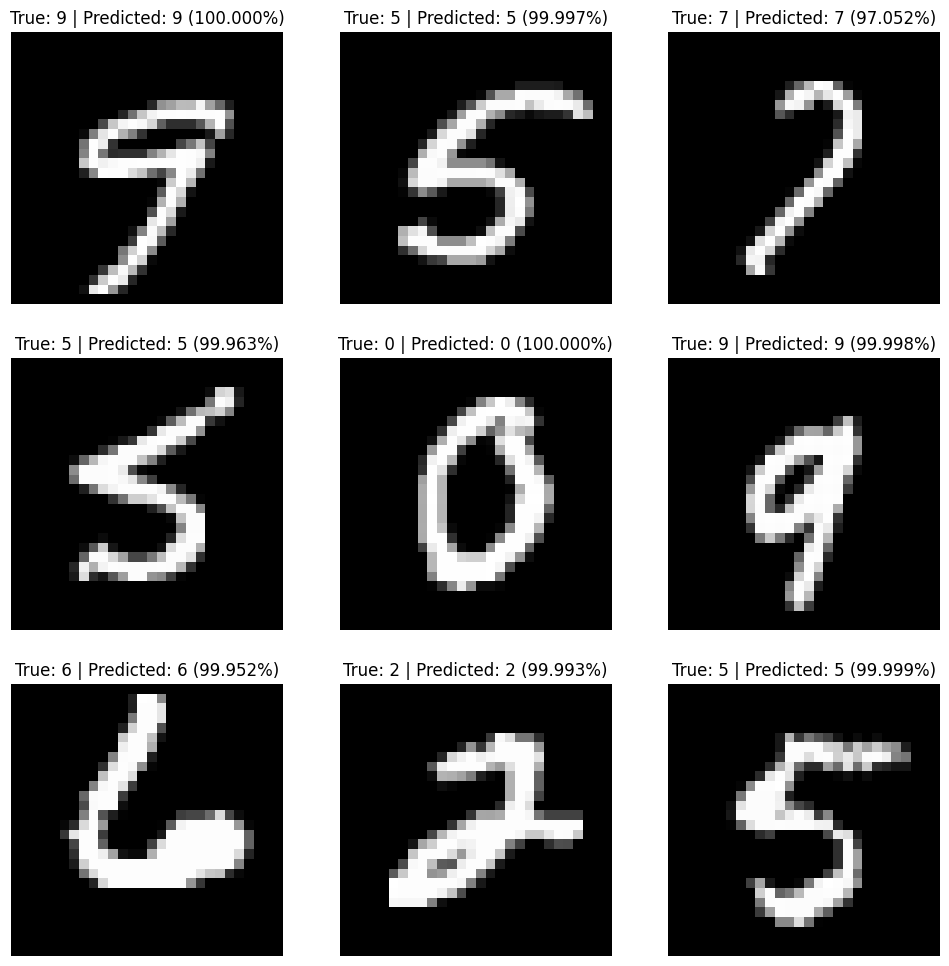

In [14]:
torch.manual_seed(42)
rows, cols = 3, 3
fig = plt.figure(figsize=(12, 12))
for i in range(1, rows*cols+1):
    random_idx = torch.randint(1, len(test_data), size=[1]).item()
    image, label = test_data[random_idx]

    model.eval()

    with torch.inference_mode():
        logits_predicted = model(image.unsqueeze(dim=0).to(device)) 
        label_predicted = torch.softmax(logits_predicted.squeeze(), dim=0).argmax(dim=0).item()
        pred_prob = torch.softmax(logits_predicted.squeeze(), dim=0)[label_predicted]

    fig.add_subplot(rows, cols, i)
    plt.imshow(image.squeeze(), cmap="gray")
    plt.axis(False)
    plt.title(f"True: {label} | Predicted: {label_predicted} ({(pred_prob * 100):.3f}%)")
